# Taller 2

In [64]:
%pylab inline
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#Importación de librerias de scipy y matplotlib

Populating the interactive namespace from numpy and matplotlib


### Datos relevantes del kart:

In [65]:
rho=1.1955 #Densidad del aire
ald=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (si estatura del piloto es de 1.68 m) (m)
Af=ald*alj #Area frontal del kart
Cd=0.89 #Coeficiente de arrastre
dp=11.0 # Dientes del piñon
dpl=39.0 # Dientes del plato
ng=dpl/dp # Relación de Transmisión
eta=0.95 #Eficiencia de la transmisión


Ie=5.2E-3 # Inercia del motor (kg m^2)

#Datos llantas
mfw=1.43 # Masa llantas traseras (kg)
mrw=1.20 # Masa llantas delanteras (kg)
rfw=0.129 # Radio llantas delanteras (m)
rinf=0.0631 # Radio rin llantas delanteras (m)
rrw=0.139 # Radio geométrico de las llantas en traseras (m)
rinr=0.0631 #radio rin llanta trasera (m)
refc=0.98*rrw # Radio efectivo llantas traseras (m)
mbt=0.7*mrw # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mrw # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mfw # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mfw # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
Ifw=(mbd*rfw)+(mdd*(rfw**2-rinf**2))/2 # Inercia 1 llanta delantera (kg-m^2)
Irw=(mbt*rrw)+(mdt*(rrw**2-rinr**2))/2 # Inercia 1 llanta trasera (kg-m^2)

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)
Ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)


# Datos Kart general
masa=152.0 # masa del Kart (kg)
masa_piloto=62 #(kg)
masat=masa+masa_piloto
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)
Tf=17 #Torque al aplicar freno(Nm) 

# Variables de tiempo para aceleración
t_in=0
t_fin=50
deltat=1000
t=linspace(t_in,t_fin,deltat)

# condiciones iniciales de aceleración
x_0=0
v_0=0.01
c_ini=[x_0,v_0]

## Requerimiento 2

In [72]:
def torque(w): #Le entra velocidad angular en rpm. Se realiza el ajuste a los datos iniciales de torque para no tener discontinuidades
    P=((-0.00000004564538677*w**3)+(0.0001056995459*w**2)
                  +(1.53209191*w))-1.895523696
    T=P/(w*2*pi/60)
    if size(w)>1:
        for i in range(size(w)):
            if w[i]<50:
                T[i]=14.31775979799432
            if T[i]>38: #limitación de torque máximo del motor
                T[i]=38
    if size(w)==1:
        if T>38:
            T=38
    
    return T
    

## Funciones utilizadas

In [73]:
def arrastre(V): #Cálculo de fuerza de arrastre, dependiente de la velocidad.
    Fd=0.5*rho*Af*Cd*V**2
    return Fd

def omega(V): #Cálculo de la velocidad angular. Se límita a 5000 por el motor. Se retorna en RPM.
    w=(V*ng/refc)*60/(2*pi)
    if w>=5000:
        w=5000
    return w

def frodadura_const(V,w):
    fr=0.01*(1+(V/100.0)) # Factor de rodadura. La velocidad del kart debe estar en (km/h)
    return w*2*pi/60*fr # (N)

def ftraccion(T): #cálculo de fuerza de tracción
    return T*ng*eta/refc

def masa_eq_r(Ie): #Cálculo de masa equivalente 
    meq=((Ie*ng**2)+Ieje+Ifw*2+Irw*2)/refc**2
    return meq

def aceleraciongrafica(w): #graficación de aceleración
    v=w*refc/ng*2*pi/60
    frod = frodadura_const(v*3.6,w)
    farr = arrastre(v)
    T=torque(w)
    acel=(ftraccion(T)-frod-farr)/(masa_eq_r(Ie)+masat)
    plt.plot(w,acel)
    plt.xlabel('Velocidad angular (RPM)')
    plt.ylabel('Aceleración (m/s)')
    
    return plt.show()

def graficaposicion(tacel,solucionacel,tdes,soluciondes):      #Gráfica de posición. Le entra tiempo de aceleración,
    plt.plot(tacel,solucionacel[:,0],'b',label='Posición (m)')    #solución de de odeint de aceleracion, tiempo de desaceleracion
    plt.plot(tdes,soluciondes,'b')                                 # y solución de desaceleración.
    plt.xlabel('Tiempo (s)')
    plt.ylabel('posición (m)')
    plt.grid()
    return plt.show()

def graficavelocidad(tacel,solucionacel,tdes,soluciondes):
    plt.plot(tacel,solucionacel[:,1],'g',label='Posición (m)')
    plt.plot(tdes,soluciondes,'g')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('velocidad (m/s)')
    plt.grid()
    return plt.show()

def aceleracion(y,t0):
    x,v = y
    vel_motor= omega(v)
    frod = frodadura_const(v*3.6,vel_motor)
    farr = arrastre(v)
    T=torque(vel_motor)
    dydt=[v,(ftraccion(T)-frod-farr)/(masa_eq_r(Ie)+masat)]
    return dydt

def desaceleracion(y,t0):
    x,v = y
    vel_motor= omega(v)
    frod = frodadura_const(v*3.6,vel_motor)
    farr = arrastre(v)
    T=torque(vel_motor)
    dydt=[v,(-Tf/refc-frod-farr)/(masa_eq_r(Ie)+masat)]
    return dydt 

In [52]:
sol=odeint(aceleracion,c_ini,t)

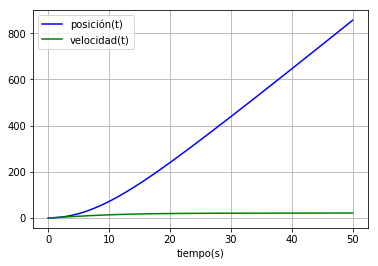

In [53]:
plt.plot(t, sol[:,0], 'b', label='posición(t)')
plt.plot(t, sol[:, 1], 'g', label='velocidad(t)')
plt.xlabel('tiempo(s)')
plt.legend(loc='best')
plt.grid()
plt.show()

In [54]:
v_1=max(sol[:,1])  #velocidad máxima aproximada del kart en m/s. Se asume que es la última posición, donde ya se ha estabilizado.
x_1=sol[999,0] #Obtención de posición donde se llega a a velocidad máxima.
c_ini2=[x_1,v_1]  # condiciones iniciales para desaceleración.

In [51]:
def aceleracion(y,t0):
    x,v = y
    vel_motor= omega(v)
    frod = frodadura_const(v*3.6,vel_motor)
    farr = arrastre(v)
    T=torque(vel_motor)
    dydt=[v,(ftraccion(T)-frod-farr)/(masa_eq_r(Ie)+masat)]
    return dydt 

In [56]:
t_des=linspace(t_fin,100)

In [57]:
sol2=odeint(desaceleracion,c_ini2,t_des)

In [58]:
frenado=sol2[:,1][sol2[:,1]>0]
posicionfreno=sol2[:,0][0:size(frenado)]
tiempofrenado=t_des[0:size(frenado)]

In [55]:
def desaceleracion(y,t0):
    x,v = y
    vel_motor= omega(v)
    frod = frodadura_const(v*3.6,vel_motor)
    farr = arrastre(v)
    T=torque(vel_motor)
    dydt=[v,(-Tf/refc-frod-farr)/(masa_eq_r(Ie)+masat)]
    return dydt 

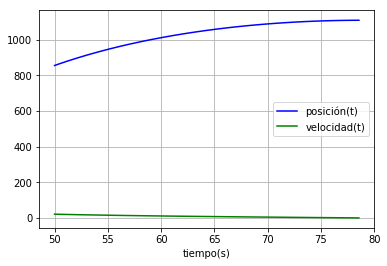

In [59]:
plt.plot(tiempofrenado, posicionfreno, 'b', label='posición(t)')
plt.plot(tiempofrenado, frenado, 'g', label='velocidad(t)')
plt.xlabel('tiempo(s)')
plt.legend(loc='best')
plt.grid()
plt.show()

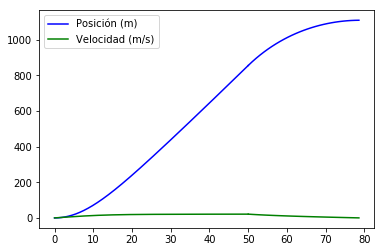

In [60]:
plt.plot(t,sol[:,0],'b',label='Posición (m)')
plt.plot(t,sol[:,1],'g',label='Velocidad (m/s)')
plt.plot(tiempofrenado,posicionfreno,'b')
plt.legend(loc='best')
plt.plot(tiempofrenado,frenado,'g')
plt.show()

In [70]:
b=linspace(1,5000,1000)

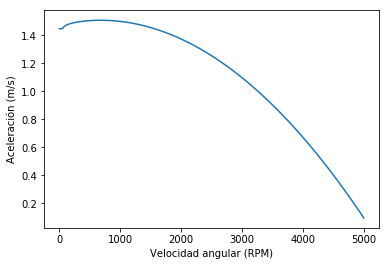

In [74]:
aceleraciongrafica(b)